In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import torch

### Check if PyTorch recognizes GPU

In [122]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Create function to extract frames from a video file

In [123]:
# https://docs.opencv.org/4.x/d8/dfe/classcv_1_1VideoCapture.html

def frame_extract(filepath, max_frames, frame_size):
    frames = []

    # begin reading from video
    capture = cv2.VideoCapture(filepath)
    if not capture.isOpened():
        print("Cannot open file")
        exit()
    while True:
        retval, image = capture.read()
        if not retval:
            break
        image = cv2.resize(image, frame_size)
        frames.append(image)

    # stop reading from video
    capture.release()

    # pad video by repeating animation until all samples are of equal length Holding -> 209
    # Pad video by repeating frames cyclically if it's shorter than max_frames
    while len(frames) < max_frames:
        num_padded = max_frames - len(frames)
        repeat_frames = frames[:num_padded]  # Repeat from the start
        frames.extend(repeat_frames)

    return np.array(frames)


#### Verify that the correct amount of frames are extracted

In [124]:
filename = 'Pointing_Day_Plain_front_30fps.mkv'
test_filepath = './dataset/Pointing/Day/Plain/' + filename
max_frames = 210 # longest animation is Holding_Something_In_Pain at 209 frames
frame_size = (52, 52)
test_frames = frame_extract(test_filepath, max_frames, frame_size)
print(test_frames.shape)# prints (num frames, height, width, channels)

(210, 52, 52, 3)


#### Display example frames from image sequence

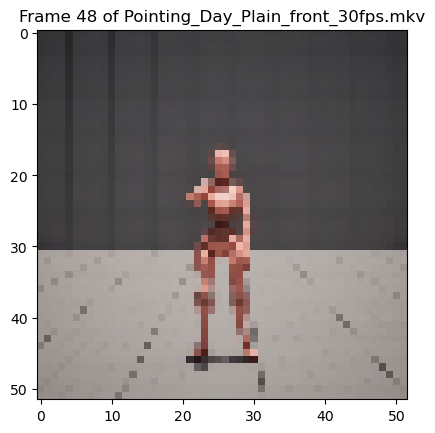

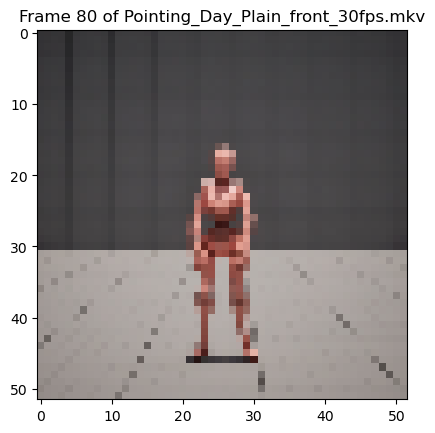

In [125]:
ex_frame1 = 48
example_frame = cv2.cvtColor(test_frames[ex_frame1], cv2.COLOR_BGR2RGB)

plt.imshow(example_frame)
plt.title(f'Frame {ex_frame1} of {filename}')
plt.show()

ex_frame2 = 80
example_frame2 = cv2.cvtColor(test_frames[ex_frame2], cv2.COLOR_BGR2RGB)
plt.imshow(example_frame2)
plt.title(f'Frame {ex_frame2} of {filename}')
plt.show()

### Define dataset with PyTorch

In [126]:
# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
from torch.utils.data import Dataset

class DistressActionDataset(Dataset):
    def __init__(self, root):
        self.root = root
        self.labels = []
        self.data = []
        #self.transform = transform
        self.label_map = {
            "Holding_Something_In_Pain": 0,
            "Injured_Walk": 1,
            "Jumping": 2,
            "Pointing": 3,
            "Running": 4,
            "Waving": 5
        }

        # add all mp4's to 'videos', and appropriate label (as filepaths) to 'labels'
        # Labels: Holding_Something_In_Pain, Injured_Walk, Jumping, Pointing, Running, Waving
        for label_folder in os.listdir(root):
            label_filepath = os.path.join(root, label_folder)
            # Times: Day, Night
            for time_folder in os.listdir(label_filepath):
                time_filepath = os.path.join(label_filepath, time_folder)
                # Environments: Rural, Plain, Grassy
                for env_folder in os.listdir(time_filepath):
                    env_filepath = os.path.join(time_filepath, env_folder)
                    # Direction: Right, Left, Front, Back
                    for video in os.listdir(env_filepath):
                        if video.endswith(".mkv"):
                            video_file = os.path.join(env_filepath, video)
                            self.data.append(video_file)
                            self.labels.append(self.label_map[label_folder])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        video_path = self.data[idx]
        label = self.labels[idx]

        frames = frame_extract(video_path, max_frames, frame_size)

        # put frames on tensor in (frames, channels, height, width) order
        # normalize pixel values
        frames = torch.from_numpy(frames).permute(0, 3, 1, 2).float() / 255.0
        # Apply transform to all frames in video
        # if self.transform:
        #     for i in range(len(frames)):
        #         frames[i] = self.transform(frames[i])
        
        # convert to tensor
        label = torch.tensor(label, dtype=torch.long)

        return frames, label

## Define Model using PyTorch

In [127]:
import torch.nn as nn
import torch.nn.functional as F
# pretrained CNN models - https://pytorch.org/vision/0.9/models.html
from torchvision.models import resnet18

class DistressClassifier(nn.Module):
    def __init__(self, classes=6):
        super().__init__()
        self.resnet = resnet18(pretrained=True)
        for param in self.resnet.parameters():
            param.requires_grad = False

        self.resnet.fc = nn.Sequential(nn.Linear(self.resnet.fc.in_features, 80))

        for param in self.resnet.fc.parameters():
            param.requires_grad = True
            
        # TODO: can stack multiple LSTM cells with 'num_layers' arg
        self.lstm = nn.LSTM(input_size=80, hidden_size=64)
        self.fc1 = nn.Linear(64, 48)
        self.fc2 = nn.Linear(48, classes)
    
    def forward(self, x):
        hidden = None

        # Iterate over each frame of a video in a video of batch * frames * channels * height * width
        for t in range(x.size(1)):
            with torch.no_grad():
                resnet_x = self.resnet(x[:, t])  
            # Pass latent representation of frame through lstm and update hidden state
            out, hidden = self.lstm(resnet_x.unsqueeze(0), hidden)         

        # Get the last hidden state
        resnet_x = self.fc1(hidden[0][-1])
        resnet_x = F.relu(resnet_x)
        resnet_x = self.fc2(resnet_x)

        return resnet_x
        #batch_size, num_frames, channels, height, width = x.shape
        #x = x.view(batch_size * num_frames, channels, height, width)

        # extract features using ResNet
        #with torch.no_grad():
        #    features = self.resnet(x)

        # reshape features to (batch_size, num_frames, feature_size)
        #features = features.view(batch_size, num_frames, -1)        

        #lstm_out, _ = self.lstm(features)

        # get last hidden state of lstm
        #last_hidden = lstm_out[:, -1, :]
        #x = self.fc1(last_hidden)
        #x = F.relu(x)
        #x = self.fc2(x)

        #return x

#### Define Transforms

In [128]:
# from torchvision.transforms import v2

# augment = v2.Compose([
#     v2.RandomHorizontalFlip(),
#     v2.RandomVerticalFlip(),
#     v2.GaussianNoise()
# ])

### Segment Dataset into Training and Test portions.

In [129]:
from torch.utils.data import random_split
dataset_path = './dataset'
dataset = DistressActionDataset(dataset_path)
# 80% of dataset set aside for training, 20% for test
train_len = int(len(dataset)*0.8)      
train_set, test_set = random_split(dataset, [train_len, len(dataset)-train_len])

### Define DataLoader, Optimizer, Loss Function, and Model

In [130]:
import torch.optim
from torch.utils.data import DataLoader

model = DistressClassifier()
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

train_dataloader = DataLoader(train_set, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=64, shuffle=True)

c:\Users\asubedi\anaconda3\envs\cmsc678\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\asubedi\anaconda3\envs\cmsc678\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Create Training Loop

In [131]:
# This training loop is modified from https://pytorch.org/tutorials/beginner/introyt/trainingyt.html

def train_model(model, train_loader, optimizer, loss_fn, epoch_count):
    for epoch_index in range(epoch_count):
        print(f"Epoch {epoch_index + 1}/{epoch_count}")
        running_loss = 0.0

        for i, data in enumerate(train_loader):
            # get sample, move to device
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero gradients
            optimizer.zero_grad()

            # make predictions for batch
            outputs = model(inputs)

            # compute loss and gradients
            loss = loss_fn(outputs, labels)
            loss.backward()

            # adjust learning weights
            optimizer.step()

            # gather training data and print periodically
            running_loss += loss.item()
        
            print(f"  Batch {i + 1} loss: {running_loss:.4f}")
            running_loss = 0.0

        print(f"Epoch {epoch_index + 1} complete. Last batch loss: {running_loss:.4f}")

### Train Model

In [132]:
epochs = 3
train_model(model, train_dataloader, optimizer, loss_fn, epochs)

Epoch 1/3
  Batch 1 loss: 1.7930
  Batch 2 loss: 1.7968
Epoch 1 complete. Last batch loss: 0.0000
Epoch 2/3
  Batch 1 loss: 1.7747
  Batch 2 loss: 1.7901
Epoch 2 complete. Last batch loss: 0.0000
Epoch 3/3
  Batch 1 loss: 1.7760
  Batch 2 loss: 1.7628
Epoch 3 complete. Last batch loss: 0.0000


### Save model weights

In [133]:
torch.save(model.state_dict(), './models/model_weights2.pth')

### Create evaluation function

In [134]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # calculate outputs by running images through the network
            outputs = model(inputs)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct // total
    print(f'Accuracy of the network: {100 * correct / total} %')
    return accuracy


# Evaluate the model on the test set
accuracy = evaluate_model(model, test_dataloader)
print(f"Test Accuracy: {accuracy:.2f}%")

Accuracy of the network: 17.24137931034483 %
Test Accuracy: 17.00%
